# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')


In [4]:
# Show index of duplicates
df_duplicate_analisys = df[df.duplicated(keep=False)]

def remove_dup(df: pd.DataFrame):
    # Now remove duplicates
    df = df.drop_duplicates()
    return df


In [5]:
# Value mapping

def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df


In [6]:
# Drop columns

def drop_columns(df: pd.DataFrame):
    df = df.drop(columns=['car'])
    #df = df.drop(columns=['toCoupon_GEQ5min'])
    df = df.drop(columns=['direction_opp'])
    return df

# Feature Engineering

toCoupon_GEQ

In [7]:
# combine toCoupon_GEQ5min’, toCoupon_GEQ15min’ and ‘toCoupon_GEQ25min’ into one column 0, 1, 2 values

#0: driving distance is less than or equal to 15 min
#1: driving distance is greater than 15 min and less than or equal to 25 min
#2: driving distance is greater than 25 min

def combine_distance_columns(df):
    """
    Combine 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', and 'toCoupon_GEQ25min' 
    columns into a single column 'to_coupon'.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    
    Returns:
    - df (pd.DataFrame): The modified dataframe with the 'to_coupon' column
    """
    
    def assign_to_coupon(row):
        if row['toCoupon_GEQ25min'] == 1:
            return 2
        elif row['toCoupon_GEQ15min'] == 1:
            return 1
        else:
            return 0

    # add the new column at penultimate position (before 'Y')
    df.insert(len(df.columns) - 1, 'to_coupon', np.nan)
    df['to_coupon'] = df.apply(assign_to_coupon, axis=1)

    # Drop the original columns
    df.drop(['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)
    
    return df


- Removed duplicates
- Applied ordinal encoding to the obvious variables (i.e. Age, Income, Temperature, the 5 frequency variables)
- Dropped car
- to_Coupon_GEQ

In [8]:
df_test1 = df.copy()

df_test1 = remove_dup(df_test1)
df_test1 = value_mapping(df_test1)
df_test1 = drop_columns(df_test1)
df_test1 = combine_distance_columns(df_test1)

Age taxonomy

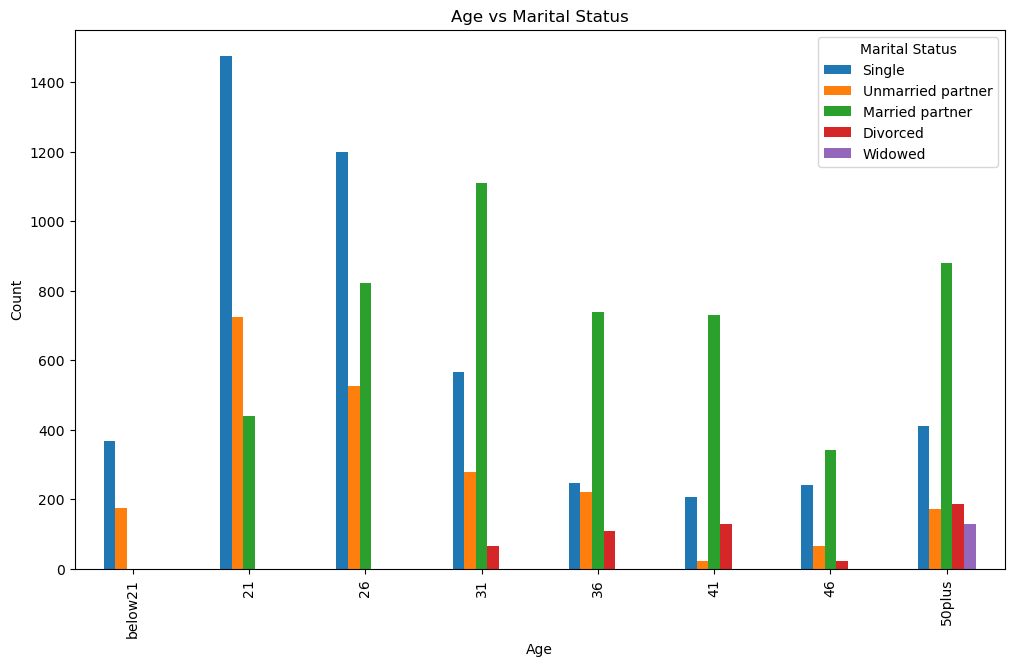

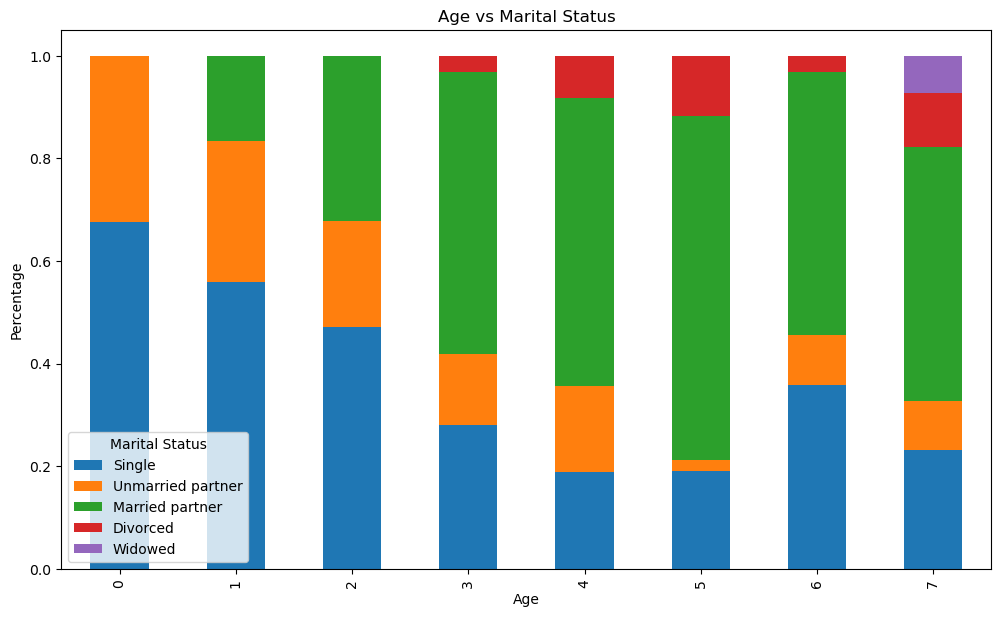

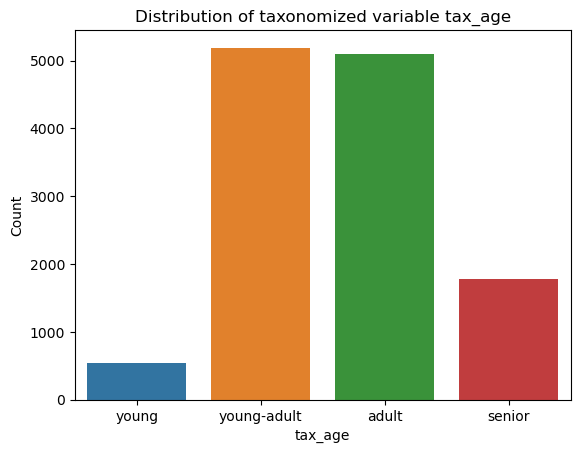

In [9]:
# analyzing age vs marital status

# defining 'age' categories order for visualization
custom_order_Age = [0, 1, 2, 3, 4, 5, 6, 7]

# defining 'maritalStatus' categories order for visualization
custom_order_MS = ['Single','Unmarried partner','Married partner','Divorced','Widowed']

# pivoting the data to get counts of each combination
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)

# ordering the data based on the custom orders
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]

# plotting grouped bar plot
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=False)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['below21', '21', '26', '31', '36', '41', '46', '50plus'])
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()


####################

# redoing this, but to analyze the percentage of each marital status per age group instead of raw counts
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]
pivot_df = pivot_df.apply(lambda x: x/x.sum(), axis=1)
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=True)
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()

# now, we create the new taxonomized variable 'tax_age'
# along the rules:
# 0: below 21 (0)                    (young)
# 1: 21, 26  (1,2)                   (young-adult)
# 2: 31, 36, 41, 46 (3,4,5,6)        (adult)
# 3: 50plus  (7)                     (senior)

df_test1['tax_age'] = df_test1['age'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else (2 if x in [3, 4, 5, 6] else 3)))

# visualizing its distribution
sns.countplot(x='tax_age', data=df_test1)
plt.xlabel('tax_age')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['young', 'young-adult', 'adult', 'senior'])
plt.title('Distribution of taxonomized variable tax_age')
plt.show()